<a href="https://colab.research.google.com/github/gennadygorin/gillespie-xenakis/blob/main/gg210728_music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gillespie-Xenakis

This notebook uses the [Magenta library](https://magenta.tensorflow.org/) to synthesize audio representations of stochastic process realizations, as simulated by the [Gillespie algorithm](https://www.sciencedirect.com/science/article/pii/0021999176900413). It is based on a [sample Magenta notebook](https://colab.research.google.com/notebooks/magenta/hello_magenta/hello_magenta.ipynb).

# Install dependencies

In [11]:
%%capture
#@test {"output": "ignore"}
print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

!pip install -qU magenta

# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

print('Importing libraries and defining some helper functions...')
from google.colab import files

import magenta
import note_seq
import tensorflow

print('🎉 Done!')
print(magenta.__version__)
print(tensorflow.__version__)

# Import package and define simulation

For now, the notebook has a very simple bursty production - isomerization - degradation reaction system:
$\varnothing \to B\times \mathcal{U} \to \mathcal{S} \to \varnothing$, where $B$ is geometrically distributed.

In [12]:
from note_seq.protobuf import music_pb2

In [13]:
#rewritten to be nonvectorized: if you want multiple cells, just run it multiple times
def gill(musicline,k,tvec,S,dt=0.1):
    n_species = S.shape[1]
    num_t_pts = len(tvec)
    X_mesh = np.empty((num_t_pts,n_species),dtype=int) #change to float if storing floats!!!!!!! 
    X_mesh[:] = np.nan
	#initialize state
    t = 0
    tindex = 0
    X = np.zeros(n_species)

	#initialize list of cells that are being simulated
    active = True
    while active:
        (t_upd,mu_upd) = rxn_calculator(X,t,k,S)
        t = t_upd
        mu = mu_upd
        tvec_time = tvec[tindex]
        update = t>tvec_time
        while update:
            X_mesh[tindex,:] = X
            tindex += 1
            ended_in_update = tindex>=num_t_pts
            if ended_in_update:
                active = False
                if not active:
                    break
            tvec_time = tvec[tindex]
            update = t>tvec_time
        not_burst = mu > 1
        burst = mu == 1
        if not_burst:
            X += S[mu-1]
            v_offs = 0
        if burst:
            bs = np.random.geometric(1/(1+S[0][0]))-1
            X += np.matlib.hstack((bs,[0]))
            v_offs = bs*3
        if active:
            if not_burst or (burst and bs>0):
                add_chord(musicline,t,dt,mu,velocity=80+v_offs)
    return X_mesh, musicline

In [14]:
def add_chord(musicline,t,dt,mu=1,inst_dict={1:10,2:11,3:12},velocity=80):
    pitch_dict = {1:[36,38,42,46],2:[37],3:[40]}
    pitch = pitch_dict[mu]
    for i in range(len(pitch)):
        musicline.notes.add(pitch=pitch[i], start_time=t, end_time=t+dt, is_drum=True, instrument=inst_dict[mu], velocity=velocity)

In [15]:
def rxn_calculator(X,t,k,S):
    nRxn = S.shape[0]
    kinit = k[0]
    a = np.zeros(nRxn,dtype=float)
    a[0] = kinit
    for i in range(1,nRxn):
	    ind = np.where(S[i,:]==-1)[0][0]
	    a[i] = X[ind]*k[i]
    a0 = np.sum(a)
    t += np.log(1./np.random.rand()) / a0
    r2ao = a0 * np.random.rand()
    mu = np.sum(r2ao >= np.cumsum(np.concatenate(([0],a))))
    return (t,mu)

In [16]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt

Define the parameters of the system. $k$ defines the transcription, splicing, and degradation rates; $bs$ defines the mean of the geometric burst distribution; $S$ defines the reaction stoichiometry matrix (where the burst size is stored in the first entry for convenience). $T$ is the simulation time horizon.

In [17]:
k = [0.4,1,1]
T = 100
# measure_time = T/min(k)
measure_time = T
bs=10
S = np.asarray([[bs,0],[-1,1],[0,-1]])
tvec = np.linspace(0,measure_time,1000,endpoint=True)

Define the drum sequence and run the simulation!

In [18]:
drums = music_pb2.NoteSequence()
drums.total_time = T

drums.tempos.add(qpm=120)
X,drums=gill(drums,k,tvec,S)

Plot the simulation trajectory.

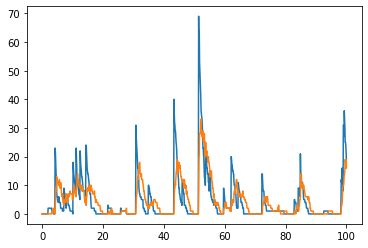

In [19]:
plt.plot(tvec,X)

Visualize and play the sequence. A transcription event has several notes (with strike velocity modulated by burst size), other reactions only one. 

In [20]:
note_seq.plot_sequence(drums)
note_seq.play_sequence(drums,synth=note_seq.fluidsynth)